<a href="https://colab.research.google.com/github/Hezily/AutoScaleX-AV-Prototype/blob/main/AutoScaleX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y swig
!pip install box2d-py pygame==2.5.2
!pip install gym==0.25.2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import gym
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from IPython.display import display, clear_output


In [ ]:
# Set parameters
replay_buffer_size = 10000
num_episodes = 3  # Reduced for Colab runtime
max_steps_per_episode = 3000
batch_size = 32
gamma = 0.99
learning_rate = 0.001

In [ ]:
# Initialize environment
env = gym.make("CarRacing-v2", render_mode="rgb_array")
obs = env.reset()

In [ ]:
# Initialize replay buffer
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def preprocess_frame(frame):
    if frame is None or not isinstance(frame, np.ndarray):
        return np.zeros((84, 84))
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray = gray / 255.0
    processed_frame = cv2.resize(gray, (84, 84))
    return processed_frame

In [ ]:
def normalize_rewards(rewards):
    rewards = np.array(rewards)
    return (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-5)

In [ ]:
def build_model(input_shape, output_dim):
    model = Sequential([
        Conv2D(32, (8, 8), strides=4, activation="relu", input_shape=input_shape),
        Conv2D(64, (4, 4), strides=2, activation="relu"),
        Conv2D(64, (3, 3), strides=1, activation="relu"),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(output_dim, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    return model

In [ ]:
def train_dqn_model(model, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    for idx in indices:
        state, action, reward, next_state, done = replay_buffer[idx]

        state = np.expand_dims(state, axis=-1)
        next_state = np.expand_dims(next_state, axis=-1)

        target = reward
        if not done:
            target += gamma * np.amax(model.predict(np.expand_dims(next_state, axis=0), verbose=0))

        target_f = model.predict(np.expand_dims(state, axis=0), verbose=0)
        # Simplified: assume discrete actions, take the index of max
        a_idx = np.argmax(action)
        target_f[0][a_idx] = target

        model.fit(np.expand_dims(state, axis=0), target_f, epochs=1, verbose=0)

Episode 3/3 finished after 1000 steps


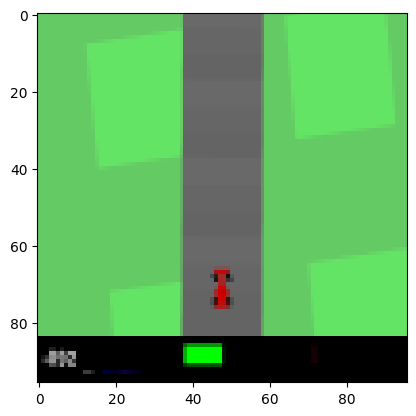

In [ ]:
from IPython.display import display, clear_output

# Your preprocess_frame function should be defined above this loop
# Your replay_buffer should be initialized before this loop

for episode in range(num_episodes):
    obs = env.reset()
    state = preprocess_frame(obs)
    done = False
    step = 0

    while not done and step < max_steps_per_episode:
        action = env.action_space.sample()
        action = [float(a) for a in action]  # Convert to native Python floats
        action[2] = 1.0  # Full throttle

        next_obs, reward, done, info = env.step(action)  # 4 values only

        next_state = preprocess_frame(next_obs)

        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        step += 1

        if step % 50 == 0:
            plt.imshow(next_obs)
            display(plt.gcf())
            clear_output(wait=True)

    print(f"Episode {episode + 1}/{num_episodes} finished after {step} steps")
